In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from tqdm import tqdm

# Data Loading and Preprocessing
def load_all_folds(base_path):
    folds = ["Fold 1", "Fold 2", "Fold 3"]
    all_images, all_masks, all_types = [], [], []
    
    for fold in folds:
        fold_path = os.path.join(base_path, fold)
        images = np.load(os.path.join(fold_path, "images", f"fold{fold[-1]}", "images.npy"))
        masks = np.load(os.path.join(fold_path, "masks", f"fold{fold[-1]}", "masks.npy"))
        types = np.load(os.path.join(fold_path, "images", f"fold{fold[-1]}", "types.npy"))
        
        all_images.append(images)
        all_masks.append(masks)
        all_types.append(types)
    
    return all_images, all_masks, all_types

base_path = "/rsrch5/home/plm/yshokrollahi/vitamin-p/vitamin-p/data/raw/H&E"
all_images, all_masks, all_types = load_all_folds(base_path)

def create_train_val_test_split(all_images, all_masks, all_types):
    splits = []
    
    for test_fold in range(3):
        train_val_folds = [i for i in range(3) if i != test_fold]
        
        train_val_images = np.concatenate([all_images[i] for i in train_val_folds])
        train_val_masks = np.concatenate([all_masks[i] for i in train_val_folds])
        train_val_types = np.concatenate([all_types[i] for i in train_val_folds])
        
        num_samples = len(train_val_images)
        num_val = num_samples // 10
        
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        
        val_indices = indices[:num_val]
        train_indices = indices[num_val:]
        
        split = {
            'train': {
                'images': train_val_images[train_indices],
                'masks': train_val_masks[train_indices],
                'types': train_val_types[train_indices]
            },
            'val': {
                'images': train_val_images[val_indices],
                'masks': train_val_masks[val_indices],
                'types': train_val_types[val_indices]
            },
            'test': {
                'images': all_images[test_fold],
                'masks': all_masks[test_fold],
                'types': all_types[test_fold]
            }
        }
        
        splits.append(split)
    
    return splits

data_splits = create_train_val_test_split(all_images, all_masks, all_types)
print("done")


/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


done


In [2]:
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
from scipy.ndimage import gaussian_filter, map_coordinates
from skimage.segmentation import slic

class CellSegmentationDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None, augment=False):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Normalize image to 0-1 range and convert to float32
        image = ((image - image.min()) / (image.max() - image.min())).astype(np.float32)
        
        # Create binary mask from the last channel and convert to float32
        binary_mask = (mask[..., 5] > 0).astype(np.float32)

        if self.augment:
            image, binary_mask = self.apply_augmentation(image, binary_mask)

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            binary_mask = self.mask_transform(binary_mask)

        return image, binary_mask

    def apply_augmentation(self, image, mask):
        # Convert numpy arrays to tensors
        image = torch.from_numpy(image).permute(2, 0, 1)
        mask = torch.from_numpy(mask).unsqueeze(0)

        original_size = image.shape[1:]

        # Random 90-degree rotation
        if torch.rand(1) < 0.5:
            k = torch.randint(1, 4, (1,)).item()
            image = torch.rot90(image, k, [1, 2])
            mask = torch.rot90(mask, k, [1, 2])

        # Random horizontal flip
        if torch.rand(1) < 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flip
        if torch.rand(1) < 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Random scaling (downscaling)
        if torch.rand(1) < 0.5:
            scale_factor = torch.FloatTensor(1).uniform_(0.8, 1.0).item()
            new_size = [max(224, int(s * scale_factor)) for s in image.shape[1:]]
            image = TF.resize(image, new_size)
            mask = TF.resize(mask, new_size)

        # Elastic transformation
        if torch.rand(1) < 0.5:
            image = self.elastic_transform(image.permute(1, 2, 0).numpy())
            mask = self.elastic_transform(mask.squeeze().numpy())
            image = torch.from_numpy(image).permute(2, 0, 1)
            mask = torch.from_numpy(mask).unsqueeze(0)

        # Ensure image is large enough for subsequent operations
        if min(image.shape[1:]) < 224:
            scale_factor = 224 / min(image.shape[1:])
            new_size = [int(s * scale_factor) for s in image.shape[1:]]
            image = TF.resize(image, new_size)
            mask = TF.resize(mask, new_size)

        # Blurring
        if torch.rand(1) < 0.5:
            sigma = torch.FloatTensor(1).uniform_(0.1, 2.0).item()
            image = torch.from_numpy(gaussian_filter(image.numpy(), sigma=(0, sigma, sigma)))

        # Gaussian noise
        if torch.rand(1) < 0.5:
            noise = torch.randn_like(image) * 0.1
            image = image + noise
            image = torch.clamp(image, 0, 1)

        # Color jittering
        if torch.rand(1) < 0.5:
            brightness_factor = torch.tensor(1.0).uniform_(0.8, 1.2).item()
            contrast_factor = torch.tensor(1.0).uniform_(0.8, 1.2).item()
            saturation_factor = torch.tensor(1.0).uniform_(0.8, 1.2).item()
            hue_factor = torch.tensor(1.0).uniform_(-0.1, 0.1).item()
            image = TF.adjust_brightness(image, brightness_factor)
            image = TF.adjust_contrast(image, contrast_factor)
            image = TF.adjust_saturation(image, saturation_factor)
            image = TF.adjust_hue(image, hue_factor)

        # SLIC superpixels
        if torch.rand(1) < 0.5:
            image = self.apply_slic(image)

        # Zoom blur
        if torch.rand(1) < 0.5:
            image = self.zoom_blur(image)

        # Random cropping with resizing
        if torch.rand(1) < 0.5:
            i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(224, 224))
            image = TF.crop(image, i, j, h, w)
            mask = TF.crop(mask, i, j, h, w)

        # Resize back to original size
        image = TF.resize(image, original_size)
        mask = TF.resize(mask, original_size)

        return image, mask

    def elastic_transform(self, image, alpha=1, sigma=0.1, alpha_affine=0.1):
        """Elastic deformation of images as described in [Simard2003]_."""
        random_state = np.random.RandomState(None)

        shape = image.shape[:2]
        
        # Random affine
        center_square = np.float32(shape) // 2
        square_size = min(shape) // 3
        pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
        pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
        M = cv2.getAffineTransform(pts1, pts2)
        image = cv2.warpAffine(image, M, shape[::-1], borderMode=cv2.BORDER_REFLECT_101)

        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

        if image.ndim == 2:
            return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
        else:
            result = np.zeros_like(image)
            for i in range(image.shape[2]):
                result[:,:,i] = map_coordinates(image[:,:,i], indices, order=1, mode='reflect').reshape(shape)
            return result

    def apply_slic(self, image):
        image_np = image.numpy().transpose(1, 2, 0)
        segments = slic(image_np, n_segments=100, compactness=10, sigma=1)
        out = np.zeros_like(image_np)
        for i in np.unique(segments):
            mask = segments == i
            out[mask] = np.mean(image_np[mask], axis=0)
        return torch.from_numpy(out.transpose(2, 0, 1))

    def zoom_blur(self, image, max_factor=1.2):
        c, h, w = image.shape
        zoom_factor = torch.FloatTensor(1).uniform_(1, max_factor).item()
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        zoom_image = TF.resize(image, (zh, zw))
        zoom_image = TF.center_crop(zoom_image, (h, w))
        return (image + zoom_image) / 2

# Usage example remains the same

# Usage example
chosen_split = 1

# Define transforms
image_transform = transforms.Compose([
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else torch.from_numpy(x).permute(2, 0, 1)),
    transforms.Lambda(lambda x: x.float())
])

mask_transform = transforms.Compose([
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else torch.from_numpy(x).unsqueeze(0)),
    transforms.Lambda(lambda x: x.float())
])

# Create datasets
train_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['train']['images'],
    data_splits[chosen_split]['train']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform,
    augment=True  # Enable augmentation for training set
)

val_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['val']['images'],
    data_splits[chosen_split]['val']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform,
    augment=False  # No augmentation for validation set
)

test_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['test']['images'],
    data_splits[chosen_split]['test']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform,
    augment=False  # No augmentation for test set
)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Check first item in train_dataset
print("\nChecking first item in train_dataset:")
image, mask = train_dataset[0]
print(f"Final image shape: {image.shape}, dtype: {image.dtype}")
print(f"Final mask shape: {mask.shape}, dtype: {mask.dtype}")
print(f"Final image min: {image.min().item():.4f}, max: {image.max().item():.4f}")
print(f"Final mask min: {mask.min().item():.4f}, max: {mask.max().item():.4f}")


Checking first item in train_dataset:
Final image shape: torch.Size([3, 256, 256]), dtype: torch.float32
Final mask shape: torch.Size([1, 256, 256]), dtype: torch.float32
Final image min: 0.0056, max: 1.0000
Final mask min: 0.0000, max: 1.0000


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


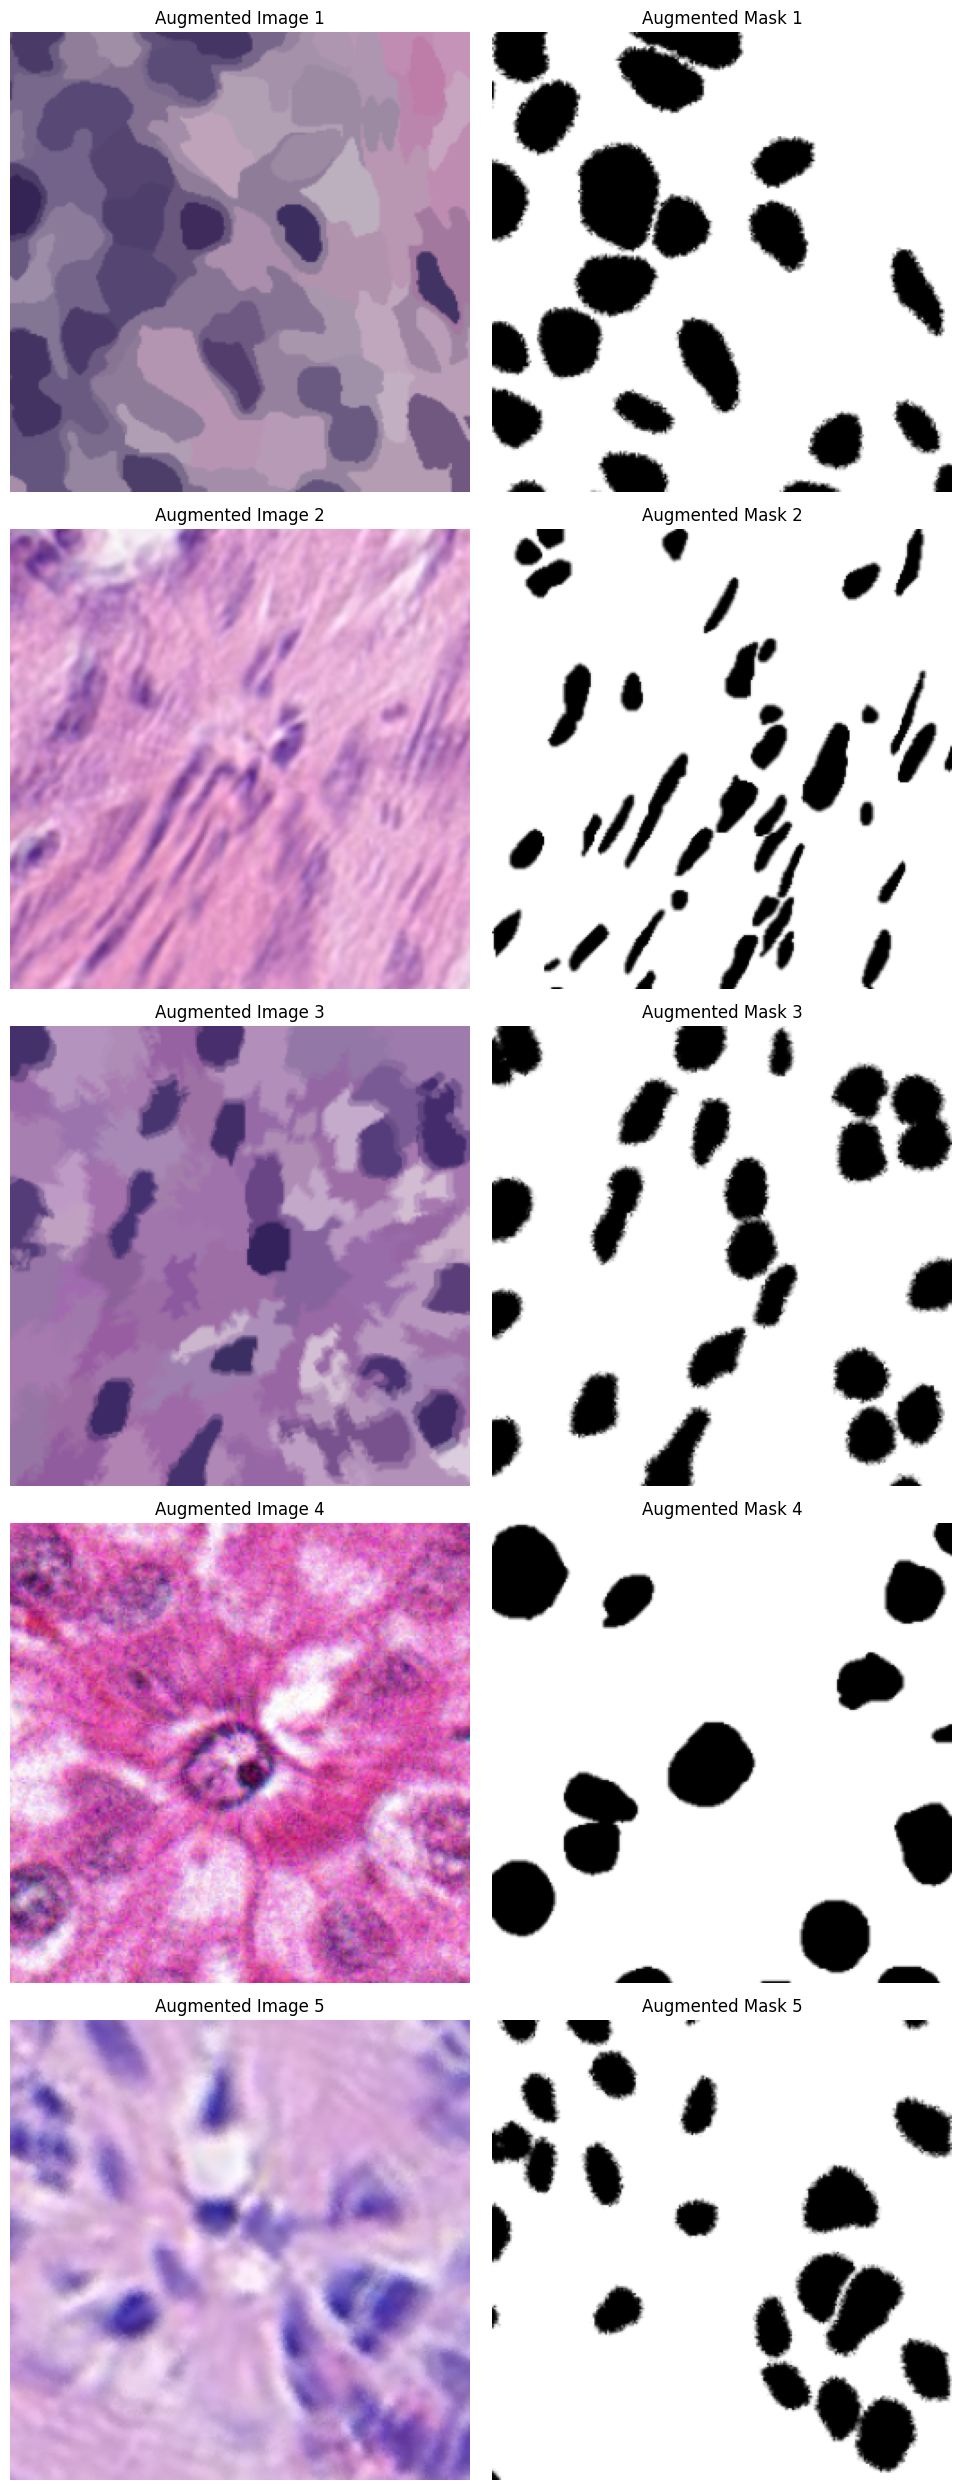

In [3]:
import matplotlib.pyplot as plt

def visualize_augmented_images(dataset, num_samples=5):
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
    for i in range(num_samples):
        image, mask = dataset[i]
        axs[i, 0].imshow(image.permute(1, 2, 0))
        axs[i, 0].set_title(f"Augmented Image {i+1}")
        axs[i, 0].axis('off')
        axs[i, 1].imshow(mask.squeeze(), cmap='gray')
        axs[i, 1].set_title(f"Augmented Mask {i+1}")
        axs[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

# Usage
visualize_augmented_images(train_dataset)

## Data visualization

Visualizing first sample from training dataset:
Original image - min: 35.0, max: 255.0, mean: 173.32258097330728
Normalized image - min: 0.0, max: 1.0, mean: 0.628739004424124


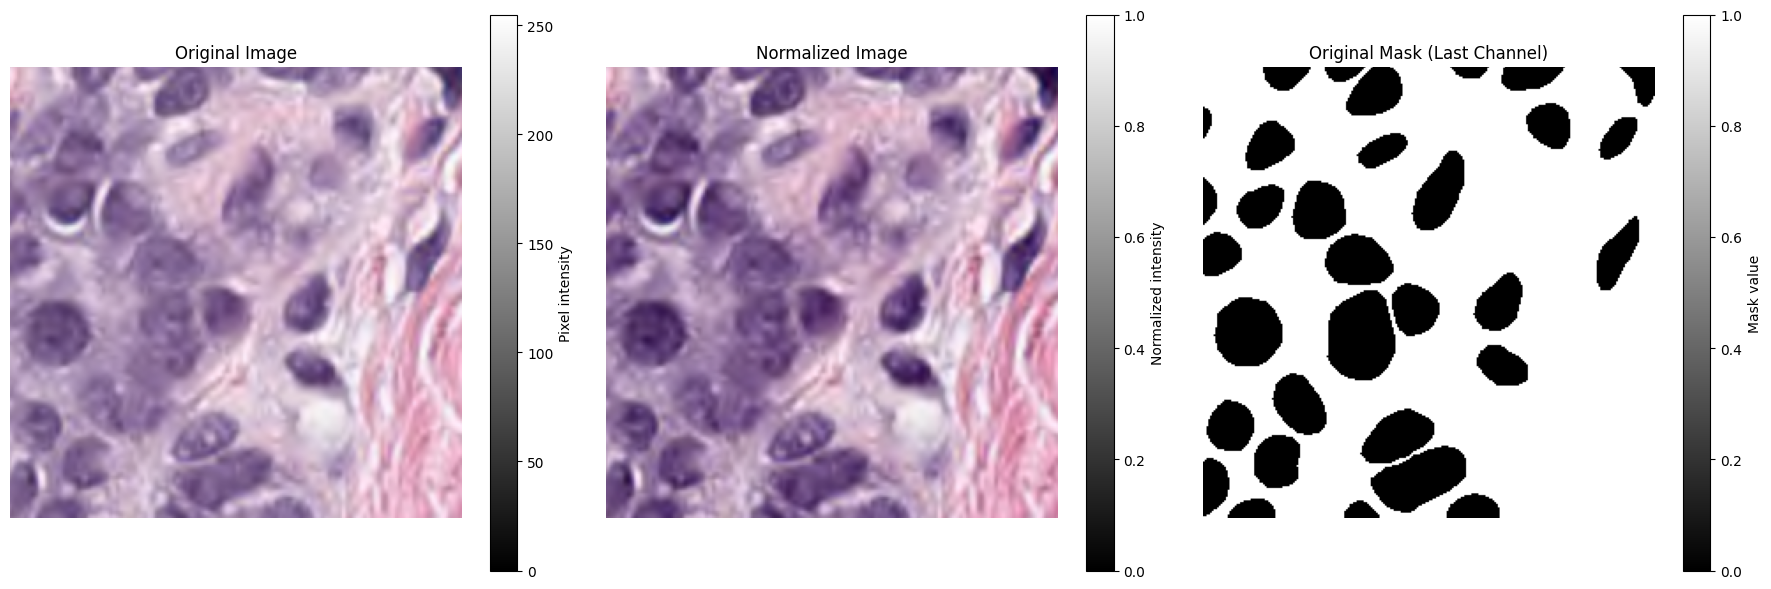

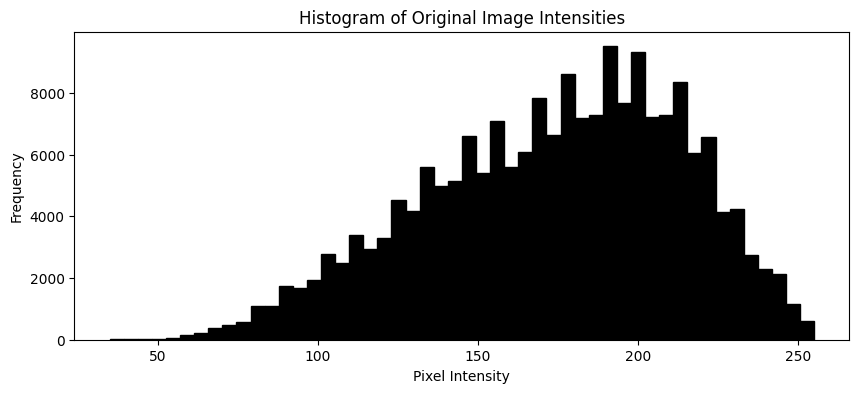

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_single_sample(dataset, index=0):
    # Get the original image and mask
    original_image = dataset.images[index]
    original_mask = dataset.masks[index]

    # Normalize image as done in the dataset class
    normalized_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

    print(f"Original image - min: {original_image.min()}, max: {original_image.max()}, mean: {original_image.mean()}")
    print(f"Normalized image - min: {normalized_image.min()}, max: {normalized_image.max()}, mean: {normalized_image.mean()}")

    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the original image
    # Plot the original image with adjusted vmin and vmax
    im1 = ax1.imshow(original_image.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
    ax1.set_title("Original Image")
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1, label='Pixel intensity')

    # Plot the normalized image
    im2 = ax2.imshow(normalized_image, cmap='gray')
    ax2.set_title("Normalized Image")
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, label='Normalized intensity')

    # Plot the original mask (last channel)
    im3 = ax3.imshow(original_mask[..., -1], cmap='gray')
    ax3.set_title("Original Mask (Last Channel)")
    ax3.axis('off')
    plt.colorbar(im3, ax=ax3, label='Mask value')

    plt.tight_layout()
    plt.show()

    # Display histogram of original image intensities
    plt.figure(figsize=(10, 4))
    plt.hist(original_image.ravel(), bins=50, range=(original_image.min(), original_image.max()), fc='k', ec='k')
    plt.title("Histogram of Original Image Intensities")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Visualize the first sample from the training dataset
print("Visualizing first sample from training dataset:")
visualize_single_sample(train_dataset)

Visualizing random samples from training dataset:

Visualiizng sample 2758:
Original image - min: 7.0, max: 255.0, mean: 198.57
Normalized image - min: 0.00, max: 1.00, mean: 0.77


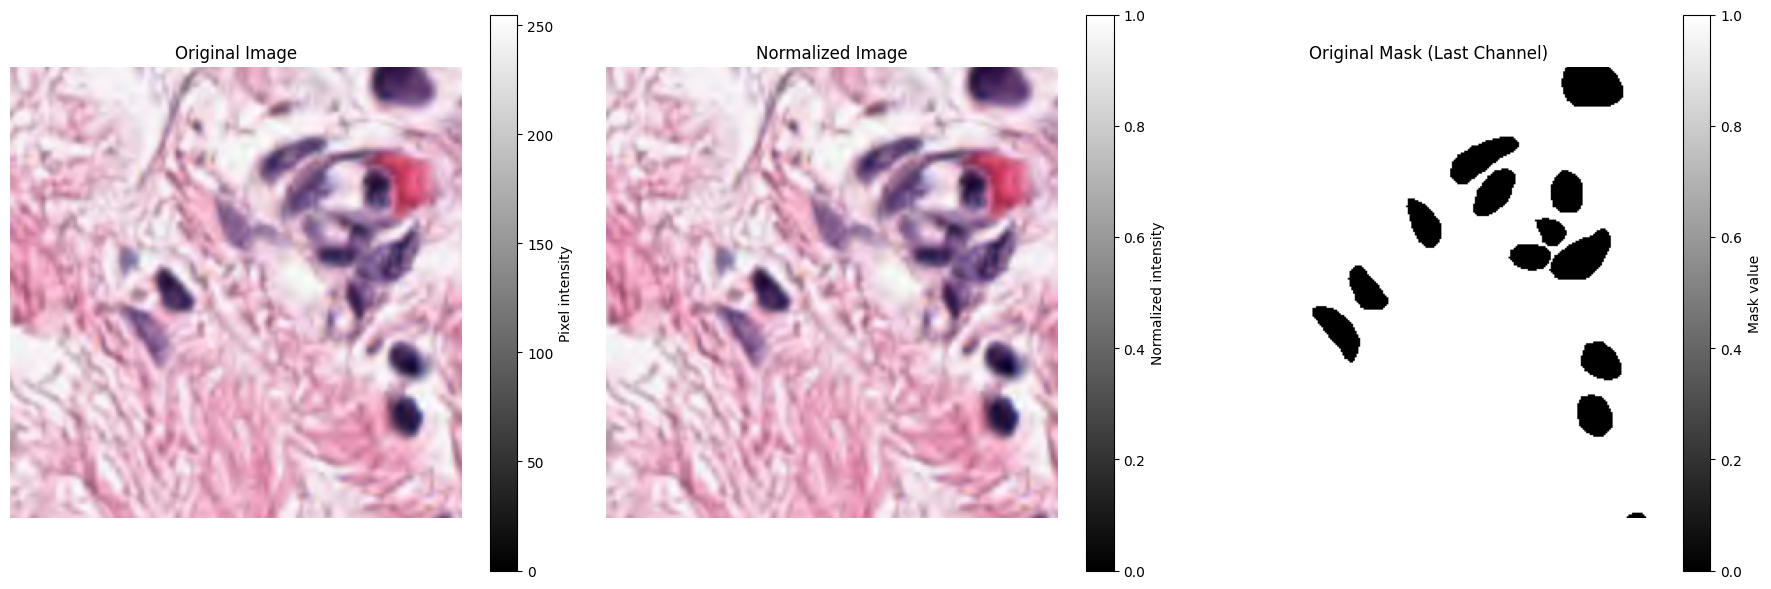


Visualiizng sample 3997:
Original image - min: 0.0, max: 255.0, mean: 88.19
Normalized image - min: 0.00, max: 1.00, mean: 0.35


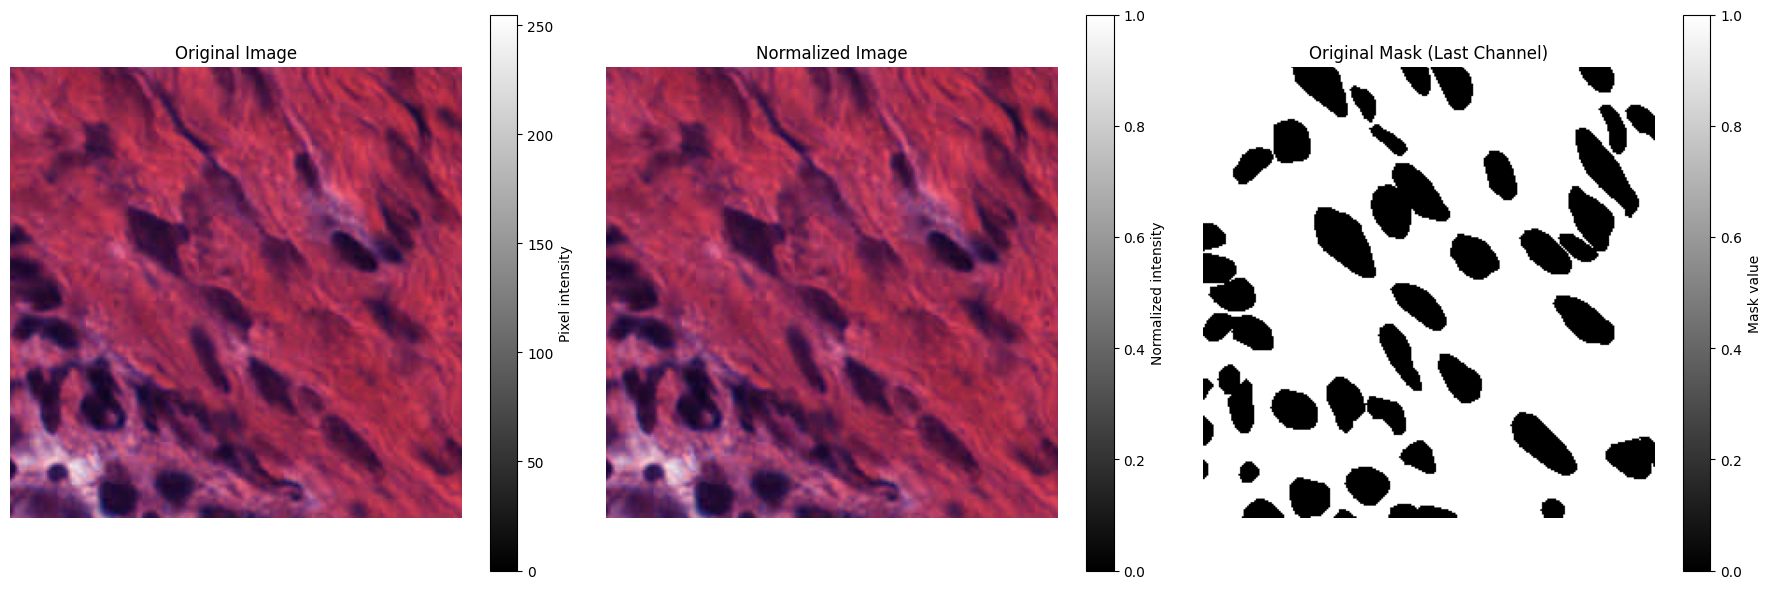


Visualiizng sample 622:
Original image - min: 3.0, max: 255.0, mean: 157.74
Normalized image - min: 0.00, max: 1.00, mean: 0.61


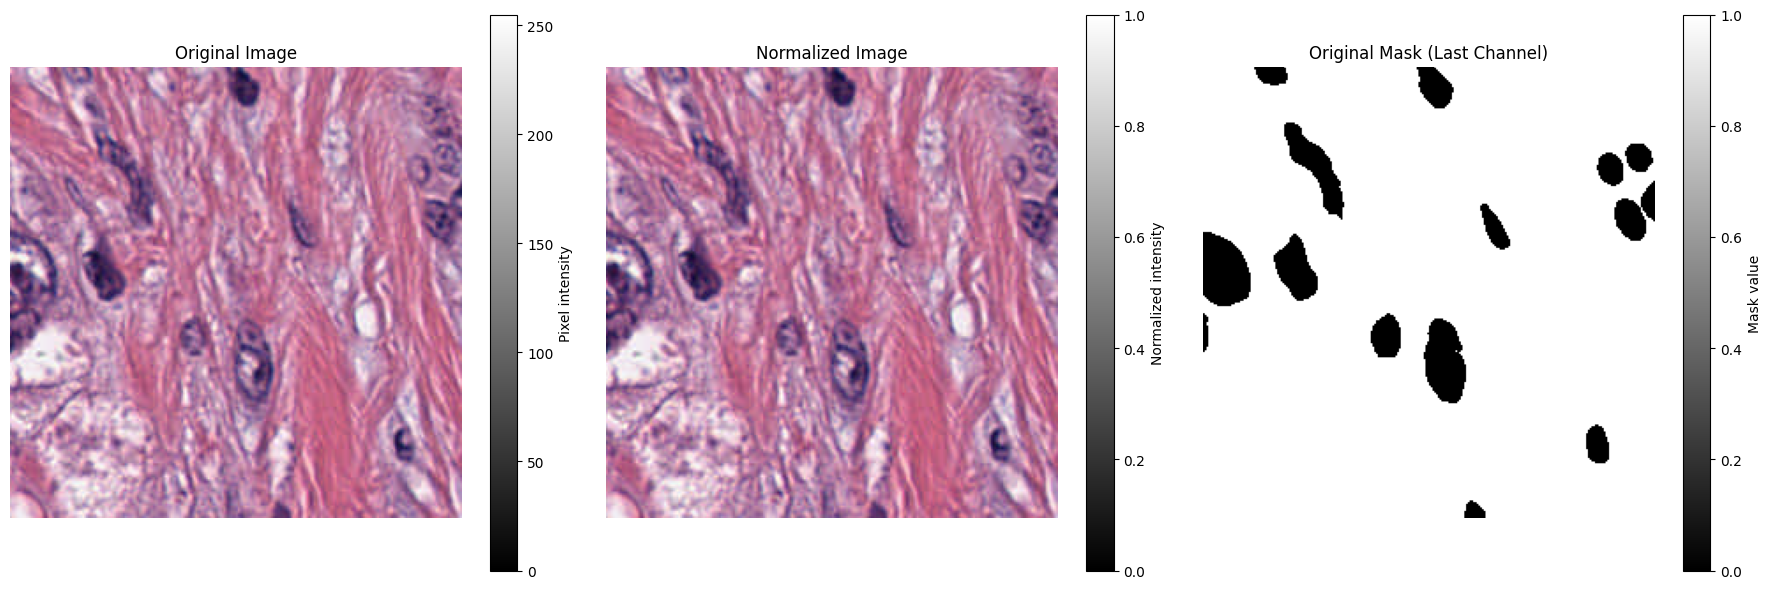

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_random_samples(dataset, num_samples=3):
    # Get the total number of samples in the dataset
    total_samples = len(dataset)
    
    # Generate random indices
    random_indices = random.sample(range(total_samples), num_samples)
    
    for index in random_indices:
        visualize_single_sample(dataset, index)

def visualize_single_sample(dataset, index):
    # Get the original image and mask
    original_image = dataset.images[index]
    original_mask = dataset.masks[index]

    # Normalize image as done in the dataset class
    normalized_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

    print(f"\nVisualiizng sample {index}:")
    print(f"Original image - min: {original_image.min()}, max: {original_image.max()}, mean: {original_image.mean():.2f}")
    print(f"Normalized image - min: {normalized_image.min():.2f}, max: {normalized_image.max():.2f}, mean: {normalized_image.mean():.2f}")

    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the original image
    im1 = ax1.imshow(original_image.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
    ax1.set_title("Original Image")
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1, label='Pixel intensity')

    # Plot the normalized image
    im2 = ax2.imshow(normalized_image, cmap='gray')
    ax2.set_title("Normalized Image")
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, label='Normalized intensity')

    # Plot the original mask (last channel)
    im3 = ax3.imshow(original_mask[..., -1], cmap='gray')
    ax3.set_title("Original Mask (Last Channel)")
    ax3.axis('off')
    plt.colorbar(im3, ax=ax3, label='Mask value')

    plt.tight_layout()
    plt.show()

    # # Display histogram of original image intensities
    # plt.figure(figsize=(10, 4))
    # plt.hist(original_image.ravel(), bins=50, range=(original_image.min(), original_image.max()), fc='k', ec='k')
    # plt.title(f"Histogram of Original Image Intensities (Sample {index})")
    # plt.xlabel("Pixel Intensity")
    # plt.ylabel("Frequency")
    # plt.show()

# Visualize random samples from the training dataset
print("Visualizing random samples from training dataset:")
visualize_random_samples(train_dataset, num_samples=3)

## model training 

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import swin_t, Swin_T_Weights

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(out_channels)

    def forward(self, x):
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.relu(self.norm2(self.conv2(x)))
        x = self.se(x)
        return x

class SwinEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        if pretrained:
            weights = Swin_T_Weights.IMAGENET1K_V1
        else:
            weights = None
        self.swin = swin_t(weights=weights)
        self.swin.head = nn.Identity()  # Remove the classifier head

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.swin.features):
            x = layer(x)
            if i in [2, 4, 6]:  # Collect features from specific layers
                features.append(x)
        return features

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UNetDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder1 = DecoderBlock(768, 384)
        self.decoder2 = DecoderBlock(384 + 384, 192)
        self.decoder3 = DecoderBlock(192 + 192, 96)
        self.decoder4 = DecoderBlock(96 + 192, 48)
        self.final_conv = nn.Conv2d(48, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
        self.attention1 = AttentionBlock(F_g=384, F_l=384, F_int=192)
        self.attention2 = AttentionBlock(F_g=192, F_l=192, F_int=96)
        self.attention3 = AttentionBlock(F_g=96, F_l=192, F_int=48)

    def forward(self, features):
        x = features[-1]
        x = x.permute(0, 3, 1, 2)  # Change from [B, H, W, C] to [B, C, H, W]
        x = self.decoder1(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        skip1 = F.interpolate(features[-2].permute(0, 3, 1, 2), size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, self.attention1(x, skip1)], dim=1)
        x = self.decoder2(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        skip2 = F.interpolate(features[-3].permute(0, 3, 1, 2), size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, self.attention2(x, skip2)], dim=1)
        x = self.decoder3(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        skip3 = F.interpolate(features[0].permute(0, 3, 1, 2), size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, self.attention3(x, skip3)], dim=1)
        x = self.decoder4(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.final_conv(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # Final upsampling to match input size
        return self.sigmoid(x)

class CellSwin(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = SwinEncoder()
        self.decoder = UNetDecoder()

    def forward(self, x):
        features = self.encoder(x)
        output = self.decoder(features)
        return output

# Initialize the model
model = CellSwin().float()
print("Improved Swin Transformer-based model defined.")

Improved Swin Transformer-based model defined.


## New Model

In [7]:
class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, smooth=1e-5):
        super(FocalDiceLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, pred, target):
        # Focal Loss
        bce = F.binary_cross_entropy(pred, target, reduction='none')
        pt = torch.exp(-bce)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce
        focal_loss = focal_loss.mean()

        # Dice Loss
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        dice = 1 - (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)

        return focal_loss + dice

def iou_score(pred, target, smooth=1e-5, threshold=0.3):
    pred = (pred > threshold).float()
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = (pred + target).sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

print("Loss function and metrics defined.")



Loss function and metrics defined.


In [28]:
import numpy as np
from scipy import ndimage
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch
import numpy as np
from scipy import ndimage

def calculate_object_based_metrics(true_mask, pred_mask, distance_threshold=12, w=[1, 1]):
    def get_centroids(mask):
        # Move tensor to CPU and convert to numpy
        mask_np = mask.cpu().numpy()
        labeled, num_objects = ndimage.label(mask_np)
        if num_objects == 0:
            return np.array([])
        centroids = ndimage.center_of_mass(mask_np, labeled, range(1, num_objects+1))
        return np.array(centroids)

    true_centroids = get_centroids(true_mask)
    pred_centroids = get_centroids(pred_mask)

    if len(true_centroids) == 0 and len(pred_centroids) == 0:
        return 1.0, 1.0, 1.0  # Perfect score if both are empty
    elif len(true_centroids) == 0 or len(pred_centroids) == 0:
        return 0.0, 0.0, 0.0  # All false positives or all false negatives

    # Create distance matrix
    distances = np.sqrt(((true_centroids[:, None, :] - pred_centroids[None, :, :]) ** 2).sum(axis=2))
    
    # Find matches
    true_matched = set()
    pred_matched = set()
    for i in range(len(true_centroids)):
        if np.min(distances[i]) <= distance_threshold:
            match_idx = np.argmin(distances[i])
            if match_idx not in pred_matched:
                true_matched.add(i)
                pred_matched.add(match_idx)

    tp_d = len(true_matched)
    fp_d = len(pred_centroids) - tp_d
    fn_d = len(true_centroids) - tp_d

    prec_d = tp_d / (tp_d + fp_d) if (tp_d + fp_d) > 0 else 0
    rec_d = tp_d / (tp_d + fn_d) if (tp_d + fn_d) > 0 else 0

    f1_d = 2 * tp_d / (2 * tp_d + w[0] * fp_d + w[1] * fn_d)

    return f1_d, prec_d, rec_d

In [29]:
import torch
from tqdm import tqdm
import os
import numpy as np

def train_model(model, train_loader, val_loader, num_epochs=100, patience=20, save_dir='models'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = FocalDiceLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
    
    os.makedirs(save_dir, exist_ok=True)
    best_val_loss = float('inf')
    best_model = None
    counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_iou = 0
        train_precision = 0
        train_recall = 0
        train_f1 = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
        for images, masks in train_bar:
            images = images.float().to(device)
            masks = masks.float().to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_iou += iou_score(outputs, masks).item()
            
            # Calculate object-based metrics
            pred_masks = (outputs > 0.5).float()
            batch_precision, batch_recall, batch_f1 = 0, 0, 0
            for true_mask, pred_mask in zip(masks, pred_masks):
                p, r, f = calculate_object_based_metrics(true_mask, pred_mask)
                batch_precision += p
                batch_recall += r
                batch_f1 += f
            
            train_precision += batch_precision / len(masks)
            train_recall += batch_recall / len(masks)
            train_f1 += batch_f1 / len(masks)
            
            train_bar.set_postfix({
                'loss': f"{loss.item():.4f}", 
                'iou': f"{iou_score(outputs, masks).item():.4f}",
                'precision': f"{batch_precision / len(masks):.4f}",
                'recall': f"{batch_recall / len(masks):.4f}",
                'f1': f"{batch_f1 / len(masks):.4f}"
            })
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_iou = train_iou / len(train_loader)
        avg_train_precision = train_precision / len(train_loader)
        avg_train_recall = train_recall / len(train_loader)
        avg_train_f1 = train_f1 / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        val_iou = 0
        val_precision = 0
        val_recall = 0
        val_f1 = 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation")
        with torch.no_grad():
            for images, masks in val_bar:
                images = images.float().to(device)
                masks = masks.float().to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_iou += iou_score(outputs, masks).item()
                
                # Calculate object-based metrics
                pred_masks = (outputs > 0.5).float()
                batch_precision, batch_recall, batch_f1 = 0, 0, 0
                for true_mask, pred_mask in zip(masks, pred_masks):
                    p, r, f = calculate_object_based_metrics(true_mask, pred_mask)
                    batch_precision += p
                    batch_recall += r
                    batch_f1 += f
                
                val_precision += batch_precision / len(masks)
                val_recall += batch_recall / len(masks)
                val_f1 += batch_f1 / len(masks)
                
                val_bar.set_postfix({
                    'loss': f"{loss.item():.4f}", 
                    'iou': f"{iou_score(outputs, masks).item():.4f}",
                    'precision': f"{batch_precision / len(masks):.4f}",
                    'recall': f"{batch_recall / len(masks):.4f}",
                    'f1': f"{batch_f1 / len(masks):.4f}"
                })
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_precision = val_precision / len(val_loader)
        avg_val_recall = val_recall / len(val_loader)
        avg_val_f1 = val_f1 / len(val_loader)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train IoU: {avg_train_iou:.4f}, Train Precision: {avg_train_precision:.4f}, Train Recall: {avg_train_recall:.4f}, Train F1: {avg_train_f1:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}, Val Precision: {avg_val_precision:.4f}, Val Recall: {avg_val_recall:.4f}, Val F1: {avg_val_f1:.4f}')
        
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
            counter = 0
            save_path = os.path.join(save_dir, 'best_model_focal_v2.pth')
            torch.save(best_model, save_path)
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")
        else:
            counter += 1
        
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    model.load_state_dict(best_model)
    return model

print("Updated training function with precision, recall, and F1 score calculations.")

Updated training function with precision, recall, and F1 score calculations.


In [30]:
!pwd

/rsrch5/home/plm/yshokrollahi/vitamin-p/new-vitamin-p


In [ ]:
# Initialize the model
model = CellSwin().float()

# Train the model
trained_model = train_model(model, train_loader, val_loader, num_epochs=100, patience=10, save_dir='models/')

Epoch 1/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.95it/s, loss=0.2229, iou=0.8983, precision=0.4852, recall=0.5556, f1=0.4954]


Epoch 1/100:
Train Loss: 0.2925, Train IoU: 0.8511, Train Precision: 0.5620, Train Recall: 0.6211, Train F1: 0.6369
Val Loss: 0.2339, Val IoU: 0.8842, Val Precision: 0.4962, Val Recall: 0.5910, Val F1: 0.5162
Saved best model with validation loss: 0.2339


Epoch 2/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.04it/s, loss=0.1642, iou=0.9065, precision=0.5154, recall=0.6667, f1=0.5139]


Epoch 2/100:
Train Loss: 0.2157, Train IoU: 0.8567, Train Precision: 0.6459, Train Recall: 0.7254, Train F1: 0.7023
Val Loss: 0.1739, Val IoU: 0.8860, Val Precision: 0.5398, Val Recall: 0.6557, Val F1: 0.5456
Saved best model with validation loss: 0.1739


Epoch 3/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.93it/s, loss=0.1297, iou=0.9035, precision=0.5043, recall=0.6389, f1=0.5694]


Epoch 3/100:
Train Loss: 0.1722, Train IoU: 0.8592, Train Precision: 0.6644, Train Recall: 0.7507, Train F1: 0.7210
Val Loss: 0.1405, Val IoU: 0.8863, Val Precision: 0.5758, Val Recall: 0.7253, Val F1: 0.5705
Saved best model with validation loss: 0.1405


Epoch 4/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.11it/s, loss=0.1121, iou=0.9043, precision=0.5340, recall=0.7037, f1=0.5694]


Epoch 4/100:
Train Loss: 0.1460, Train IoU: 0.8632, Train Precision: 0.6864, Train Recall: 0.7862, Train F1: 0.7314
Val Loss: 0.1232, Val IoU: 0.8915, Val Precision: 0.5688, Val Recall: 0.7313, Val F1: 0.5543
Saved best model with validation loss: 0.1232


Epoch 5/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.01it/s, loss=0.0987, iou=0.9092, precision=0.5043, recall=0.6389, f1=0.5694]


Epoch 5/100:
Train Loss: 0.1339, Train IoU: 0.8660, Train Precision: 0.6943, Train Recall: 0.7949, Train F1: 0.7352
Val Loss: 0.1072, Val IoU: 0.8967, Val Precision: 0.5909, Val Recall: 0.7629, Val F1: 0.5766
Saved best model with validation loss: 0.1072


Epoch 6/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.18it/s, loss=0.1021, iou=0.9112, precision=0.5109, recall=0.5741, f1=0.5694]


Epoch 6/100:
Train Loss: 0.1258, Train IoU: 0.8682, Train Precision: 0.6841, Train Recall: 0.7931, Train F1: 0.7250
Val Loss: 0.1145, Val IoU: 0.9000, Val Precision: 0.5708, Val Recall: 0.6973, Val F1: 0.5716


Epoch 7/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.02it/s, loss=0.0886, iou=0.9083, precision=0.5564, recall=0.7778, f1=0.5694]


Epoch 7/100:
Train Loss: 0.1216, Train IoU: 0.8713, Train Precision: 0.7041, Train Recall: 0.8072, Train F1: 0.7425
Val Loss: 0.0925, Val IoU: 0.8974, Val Precision: 0.5986, Val Recall: 0.7875, Val F1: 0.5794
Saved best model with validation loss: 0.0925


Epoch 8/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.08it/s, loss=0.0852, iou=0.9129, precision=0.5379, recall=0.7593, f1=0.5694]


Epoch 8/100:
Train Loss: 0.1184, Train IoU: 0.8730, Train Precision: 0.7100, Train Recall: 0.8171, Train F1: 0.7486
Val Loss: 0.0897, Val IoU: 0.9085, Val Precision: 0.6053, Val Recall: 0.7711, Val F1: 0.5882
Saved best model with validation loss: 0.0897


Epoch 9/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.13it/s, loss=0.0797, iou=0.9067, precision=0.6120, recall=0.8889, f1=0.5806]


Epoch 9/100:
Train Loss: 0.1153, Train IoU: 0.8749, Train Precision: 0.7048, Train Recall: 0.8100, Train F1: 0.7466
Val Loss: 0.0862, Val IoU: 0.9046, Val Precision: 0.6215, Val Recall: 0.8219, Val F1: 0.5891
Saved best model with validation loss: 0.0862


Epoch 10/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.16it/s, loss=0.0805, iou=0.9013, precision=0.5935, recall=0.8333, f1=0.5694]


Epoch 10/100:
Train Loss: 0.1151, Train IoU: 0.8759, Train Precision: 0.7070, Train Recall: 0.8134, Train F1: 0.7496
Val Loss: 0.0889, Val IoU: 0.8960, Val Precision: 0.6213, Val Recall: 0.8348, Val F1: 0.5849


Epoch 11/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.12it/s, loss=0.0806, iou=0.9074, precision=0.6026, recall=0.7937, f1=0.5806]


Epoch 11/100:
Train Loss: 0.1131, Train IoU: 0.8764, Train Precision: 0.7120, Train Recall: 0.8147, Train F1: 0.7510
Val Loss: 0.0890, Val IoU: 0.8986, Val Precision: 0.6080, Val Recall: 0.8168, Val F1: 0.5740


Epoch 12/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.08it/s, loss=0.0808, iou=0.9123, precision=0.5354, recall=0.7037, f1=0.5694]


Epoch 12/100:
Train Loss: 0.1118, Train IoU: 0.8760, Train Precision: 0.7090, Train Recall: 0.8259, Train F1: 0.7407
Val Loss: 0.0872, Val IoU: 0.9070, Val Precision: 0.6071, Val Recall: 0.7981, Val F1: 0.5799


Epoch 13/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.99it/s, loss=0.0869, iou=0.9029, precision=0.5519, recall=0.7037, f1=0.5694]


Epoch 13/100:
Train Loss: 0.1128, Train IoU: 0.8759, Train Precision: 0.7218, Train Recall: 0.8313, Train F1: 0.7546
Val Loss: 0.0882, Val IoU: 0.8977, Val Precision: 0.6111, Val Recall: 0.8226, Val F1: 0.5778
Epoch 00013: reducing learning rate of group 0 to 1.0000e-05.


Epoch 14/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.06it/s, loss=0.0792, iou=0.9117, precision=0.5910, recall=0.7778, f1=0.5694]


Epoch 14/100:
Train Loss: 0.1088, Train IoU: 0.8790, Train Precision: 0.7241, Train Recall: 0.8438, Train F1: 0.7508
Val Loss: 0.0807, Val IoU: 0.9094, Val Precision: 0.6159, Val Recall: 0.8168, Val F1: 0.5839
Saved best model with validation loss: 0.0807


Epoch 15/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.18it/s, loss=0.0774, iou=0.9116, precision=0.5679, recall=0.7407, f1=0.5806]


Epoch 15/100:
Train Loss: 0.1056, Train IoU: 0.8808, Train Precision: 0.7281, Train Recall: 0.8366, Train F1: 0.7584
Val Loss: 0.0800, Val IoU: 0.9134, Val Precision: 0.6206, Val Recall: 0.8148, Val F1: 0.5887
Saved best model with validation loss: 0.0800


Epoch 16/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.18it/s, loss=0.0778, iou=0.9111, precision=0.5540, recall=0.7222, f1=0.5694]


Epoch 16/100:
Train Loss: 0.1045, Train IoU: 0.8828, Train Precision: 0.7193, Train Recall: 0.8367, Train F1: 0.7488
Val Loss: 0.0783, Val IoU: 0.9116, Val Precision: 0.6212, Val Recall: 0.8151, Val F1: 0.5890
Saved best model with validation loss: 0.0783


Epoch 17/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.90it/s, loss=0.0788, iou=0.9130, precision=0.5799, recall=0.7222, f1=0.5694]


Epoch 17/100:
Train Loss: 0.1047, Train IoU: 0.8825, Train Precision: 0.7083, Train Recall: 0.8315, Train F1: 0.7382
Val Loss: 0.0797, Val IoU: 0.9126, Val Precision: 0.6153, Val Recall: 0.7997, Val F1: 0.5865


Epoch 18/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.18it/s, loss=0.0771, iou=0.9126, precision=0.5204, recall=0.5556, f1=0.5694]


Epoch 18/100:
Train Loss: 0.1034, Train IoU: 0.8833, Train Precision: 0.7270, Train Recall: 0.8419, Train F1: 0.7560
Val Loss: 0.0796, Val IoU: 0.9121, Val Precision: 0.6111, Val Recall: 0.8014, Val F1: 0.5830


Epoch 19/100 - Training:  21%|██        | 64/303 [00:12<00:34,  7.00it/s, loss=0.1031, iou=0.8857, precision=0.7082, recall=0.9167, f1=0.6819]

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
import random

def visualize_prediction_with_metrics(model, test_dataset, device, num_samples=3):
    model.eval()
    
    # Randomly select indices
    indices = random.sample(range(len(test_dataset)), num_samples)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    overall_f1 = 0
    overall_precision = 0
    overall_recall = 0
    
    for i, idx in enumerate(indices):
        image, mask = test_dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension
        
        with torch.no_grad():
            output = model(image)
        
        image = image.cpu().numpy().transpose(0, 2, 3, 1).squeeze()
        mask = mask.cpu().numpy().squeeze()
        output = output.cpu().numpy().squeeze()
        
        # Calculate metrics
        pred_mask = (output > 0.5).astype(np.uint8)
        f1 = f1_score(mask.flatten(), pred_mask.flatten(), average='binary')
        precision = precision_score(mask.flatten(), pred_mask.flatten(), average='binary')
        recall = recall_score(mask.flatten(), pred_mask.flatten(), average='binary')
        
        overall_f1 += f1
        overall_precision += precision
        overall_recall += recall
        
        # Plotting
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Input Image {idx}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f"True Mask {idx}")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title(f"Predicted Mask {idx}\nF1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print overall metrics
    overall_f1 /= num_samples
    overall_precision /= num_samples
    overall_recall /= num_samples
    
    print(f"Overall Metrics (average of {num_samples} samples):")
    print(f"F1 Score: {overall_f1:.4f}")
    print(f"Precision: {overall_precision:.4f}")
    print(f"Recall: {overall_recall:.4f}")

print("Enhanced visualization function with metrics defined.")

# Usage example (you'll need to define these variables):
# model = your_trained_model
# test_dataset = your_test_dataset
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# visualize_prediction_with_metrics(model, test_dataset, device)

Enhanced visualization function with metrics defined.


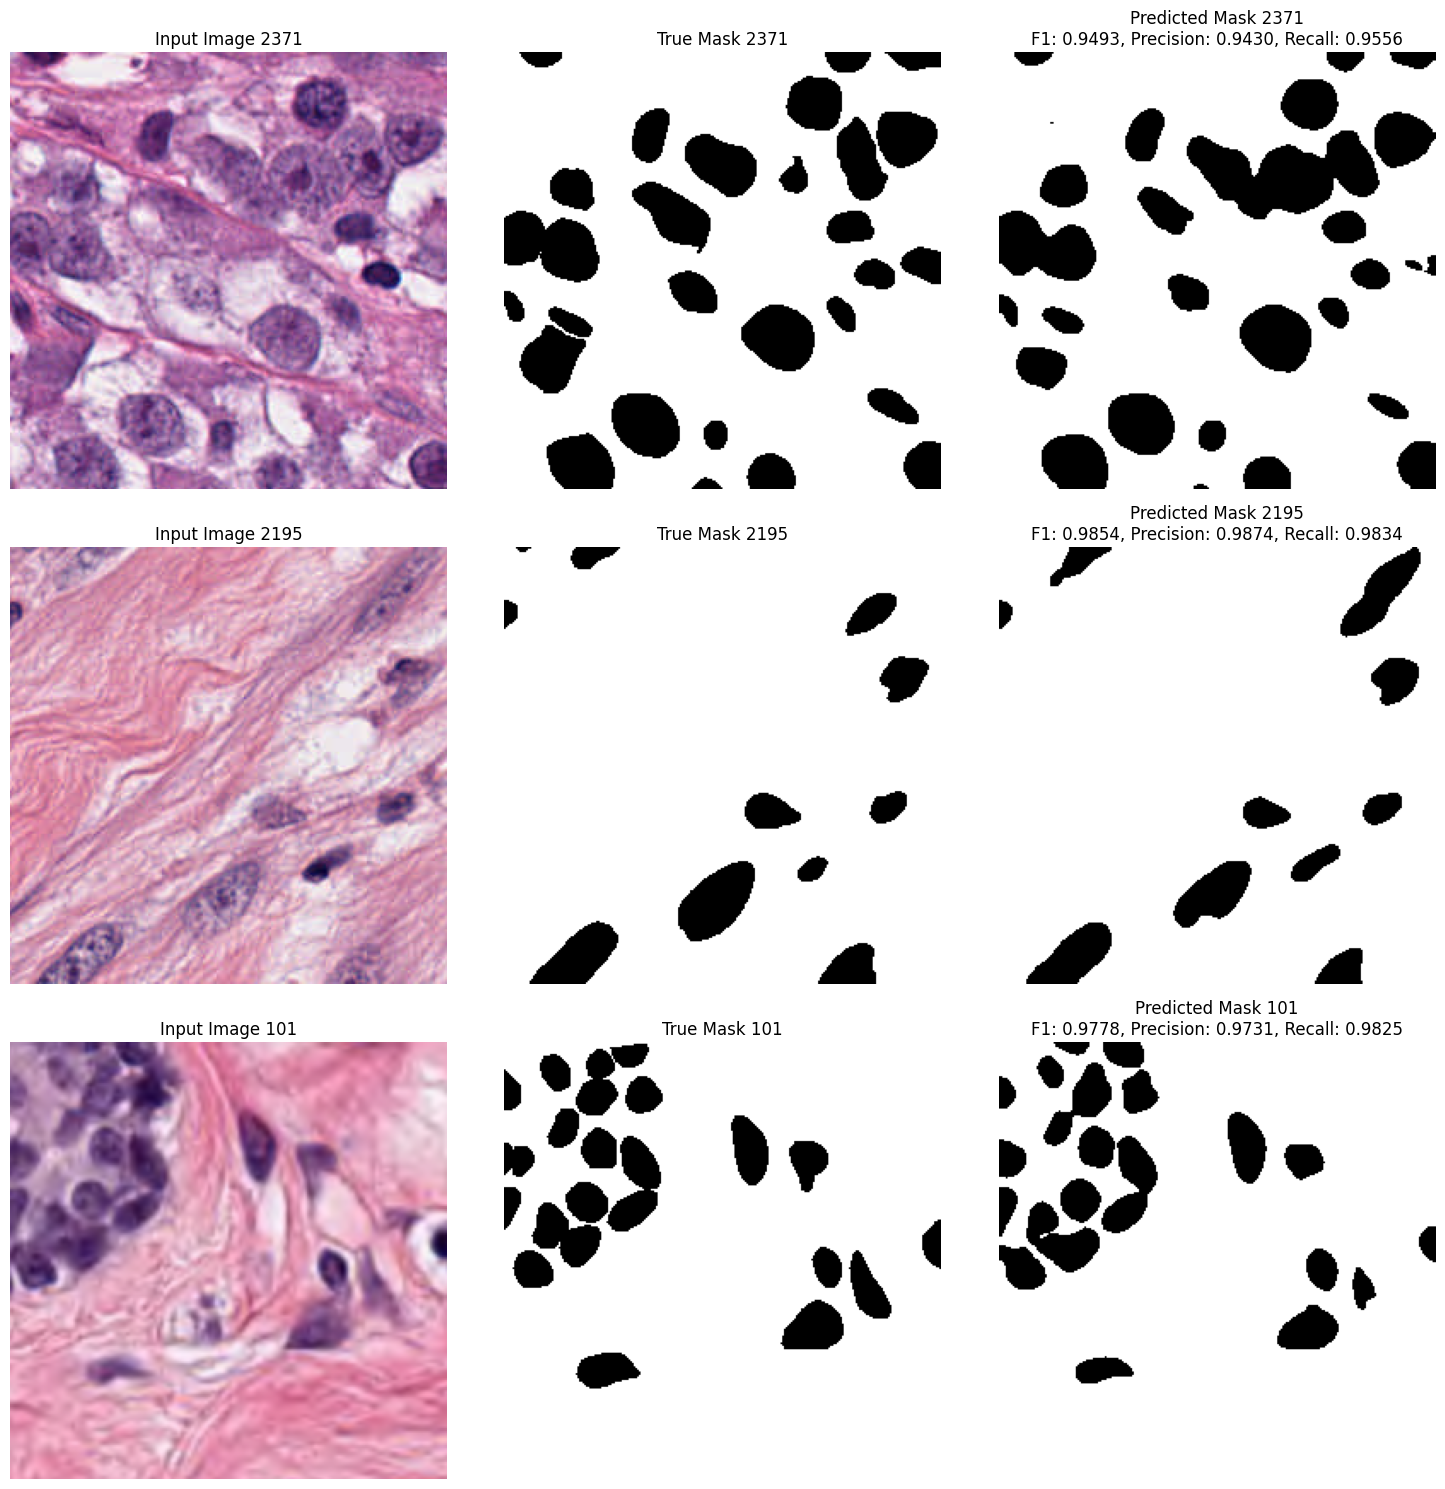

Overall Metrics (average of 3 samples):
F1 Score: 0.9708
Precision: 0.9678
Recall: 0.9738


In [33]:
model = trained_model  # Your trained CellViT model
test_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['test']['images'],
    data_splits[chosen_split]['test']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Visualize and calculate metrics
visualize_prediction_with_metrics(model, test_dataset, device, num_samples=3)

In [34]:
import numpy as np
import torch
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm
from torch.utils.data import DataLoader

def calculate_metrics_across_all_test_sets(model, test_dataset, device, batch_size=32):
    model.eval()
    
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    all_true_masks = []
    all_pred_masks = []
    
    with torch.no_grad():
        for images, masks in tqdm(test_dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            # Ensure images are in the correct shape (B, C, H, W)
            if images.dim() == 3:
                images = images.unsqueeze(1)  # Add channel dimension if missing
            
            if images.shape[-2:] != (224, 224):
                images = torch.nn.functional.interpolate(images, size=(256, 256), mode='bilinear', align_corners=False)
            
            outputs = model(images)
            pred_masks = (outputs > 0.5).float()
            
            # Resize pred_masks back to original size if necessary
            if pred_masks.shape[-2:] != masks.shape[-2:]:
                pred_masks = torch.nn.functional.interpolate(pred_masks, size=masks.shape[-2:], mode='nearest')
            
            all_true_masks.extend(masks.cpu().numpy().flatten())
            all_pred_masks.extend(pred_masks.cpu().numpy().flatten())
    
    all_true_masks = np.array(all_true_masks)
    all_pred_masks = np.array(all_pred_masks)
    
    f1 = f1_score(all_true_masks, all_pred_masks, average='binary')
    precision = precision_score(all_true_masks, all_pred_masks, average='binary')
    recall = recall_score(all_true_masks, all_pred_masks, average='binary')
    
    print("Metrics across all test sets:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    return f1, precision, recall

# Usage
model = trained_model  # Your trained CellViT model
test_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['test']['images'],
    data_splits[chosen_split]['test']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate metrics across all test sets
f1, precision, recall = calculate_metrics_across_all_test_sets(model, test_dataset, device)

Evaluating: 100%|██████████| 79/79 [00:17<00:00,  4.46it/s]


Metrics across all test sets:
F1 Score: 0.9643
Precision: 0.9611
Recall: 0.9676


In [37]:
import numpy as np
import torch
from scipy import ndimage
from tqdm import tqdm
from torch.utils.data import DataLoader

def calculate_object_based_metrics(true_mask, pred_mask, distance_threshold=12):
    def get_centroids(mask):
        labeled, num_objects = ndimage.label(mask)
        if num_objects == 0:
            return np.array([])
        centroids = ndimage.center_of_mass(mask, labeled, range(1, num_objects+1))
        return np.array(centroids)

    true_centroids = get_centroids(true_mask)
    pred_centroids = get_centroids(pred_mask)

    if len(true_centroids) == 0 and len(pred_centroids) == 0:
        return 1.0, 1.0, 1.0  # Perfect score if both are empty
    elif len(true_centroids) == 0:
        return 0.0, 0.0, 0.0  # All false positives
    elif len(pred_centroids) == 0:
        return 0.0, 0.0, 0.0  # All false negatives

    matched = set()
    tp = 0
    for pred_centroid in pred_centroids:
        distances = np.sqrt(((true_centroids - pred_centroid) ** 2).sum(axis=1))
        if distances.size > 0 and np.min(distances) <= distance_threshold:
            match_idx = np.argmin(distances)
            if match_idx not in matched:
                tp += 1
                matched.add(match_idx)

    fp = len(pred_centroids) - tp
    fn = len(true_centroids) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

    return precision, recall, f1

def calculate_metrics_across_all_test_sets(model, test_dataset, device, batch_size=32):
    model.eval()
    
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    all_precisions, all_recalls, all_f1s = [], [], []
    
    with torch.no_grad():
        for images, masks in tqdm(test_dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            # Ensure images are in the correct shape (B, C, H, W)
            if images.dim() == 3:
                images = images.unsqueeze(1)  # Add channel dimension if missing
            
            outputs = model(images)
            pred_masks = (outputs > 0.5).float()
            
            # Calculate object-based metrics for each image in the batch
            for true_mask, pred_mask in zip(masks.cpu().numpy(), pred_masks.cpu().numpy()):
                precision, recall, f1 = calculate_object_based_metrics(true_mask.squeeze(), pred_mask.squeeze())
                all_precisions.append(precision)
                all_recalls.append(recall)
                all_f1s.append(f1)
    
    avg_precision = np.mean(all_precisions)
    avg_recall = np.mean(all_recalls)
    avg_f1 = np.mean(all_f1s)
    
    print("Object-based metrics across all test sets:")

    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")
    
    return avg_f1, avg_precision, avg_recall

# Usage remains the same

# Usage
model = trained_model  # Your trained CellViT model
test_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['test']['images'],
    data_splits[chosen_split]['test']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate metrics across all test sets
f1, precision, recall = calculate_metrics_across_all_test_sets(model, test_dataset, device)

Evaluating: 100%|██████████| 79/79 [00:13<00:00,  5.99it/s]

Object-based metrics across all test sets:
Precision: 0.8312
Recall: 0.6342
F1 Score: 0.6521
